In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
num_particles = (100,)

In [16]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [17]:
def attach_proposal(model, guide, inclusive_kl=False):
    if inclusive_kl:
        return importance.Propose(guide, model)
    else:
        return importance.Propose(model, guide)

In [18]:
def attach_proposals(model, num_particles, inclusive_kl=False):
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: attach_proposal(m, init_proposal, inclusive_kl)
    model = model.apply(init_attach, init_selector)
    
    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: attach_proposal(m, step_proposal, inclusive_kl)
    return model.apply(step_attach, step_selector)

In [19]:
def training_model(num_particles, inference_strategy, inclusive_kl=False):
    model = generative_model(num_particles)
    if inclusive_kl:
        model = inference_strategy(model)
    model = attach_proposals(model, num_particles, inclusive_kl)
    if not inclusive_kl:
        model = inference_strategy(model)
    return model

In [20]:
trajectory, displacements, data = generate_trajectory_trace()

In [21]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True):
    sampler = training_model(num_particles, inference_strategy, inclusive_kl=inclusive_kl)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 100, data, use_cuda=False, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau

In [22]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [23]:
sample_sizes = [1, 10, 100]
SAMPLING_STRATEGIES = ['Importance weighting', 'Sequential Monte Carlo', 'Resample-Move Sequential Monte Carlo']
sampling_strategies = [lambda m: m, lambda m: importance.smc(m), lambda m: mcmc.resample_move_smc(m, moves=5)]
kl_directions = [False, True]

03/01/2019 13:41:06 Experimenting with sampling strategy: Importance weighting
03/01/2019 13:41:06 Experimenting with Variational training
03/01/2019 13:41:06 Experimenting with sample size of 1
03/01/2019 13:41:07 ELBO=-1.47392249e+03 at epoch 1
03/01/2019 13:41:07 ELBO=-3.46817480e+03 at epoch 2
03/01/2019 13:41:07 ELBO=-6.37280579e+02 at epoch 3
03/01/2019 13:41:07 ELBO=-5.73143738e+02 at epoch 4
03/01/2019 13:41:07 ELBO=-5.90699036e+02 at epoch 5
03/01/2019 13:41:07 ELBO=-4.75607849e+02 at epoch 6
03/01/2019 13:41:08 ELBO=-4.87115753e+02 at epoch 7
03/01/2019 13:41:08 ELBO=-4.64497437e+02 at epoch 8
03/01/2019 13:41:08 ELBO=-4.34382904e+02 at epoch 9
03/01/2019 13:41:08 ELBO=-5.18427551e+02 at epoch 10
03/01/2019 13:41:08 ELBO=-4.32674835e+02 at epoch 11
03/01/2019 13:41:08 ELBO=-4.35923645e+02 at epoch 12
03/01/2019 13:41:09 ELBO=-4.88662811e+02 at epoch 13
03/01/2019 13:41:09 ELBO=-8.30738647e+02 at epoch 14
03/01/2019 13:41:09 ELBO=-4.58012604e+02 at epoch 15
03/01/2019 13:41:09

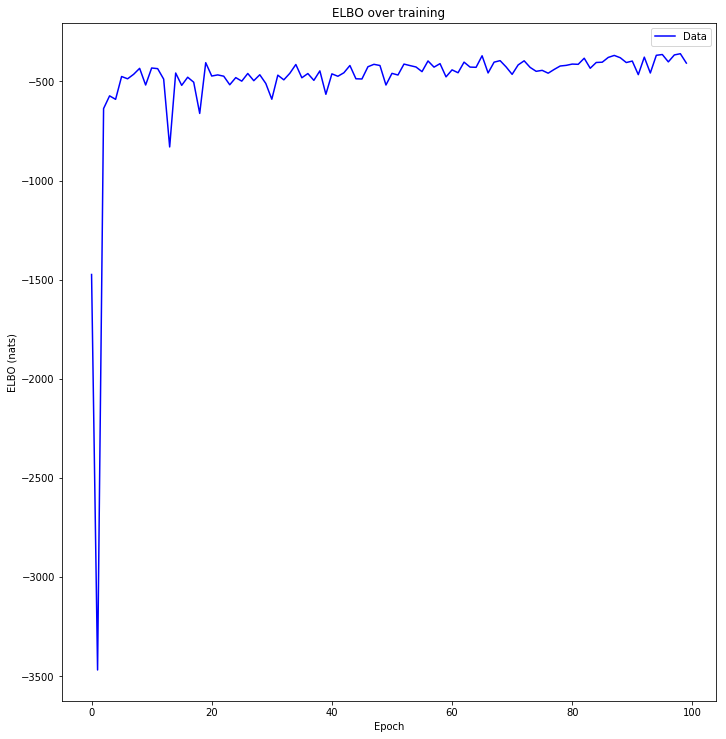

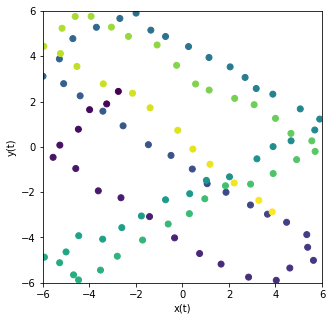

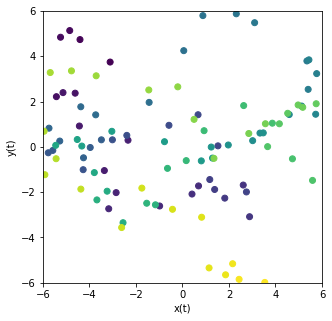

03/01/2019 13:41:24 MSE at time 0: tensor(1.8015)
03/01/2019 13:41:24 MSE at time 1: tensor(9.3852)
03/01/2019 13:41:24 MSE at time 2: tensor(12.9302)
03/01/2019 13:41:24 MSE at time 3: tensor(17.0857)
03/01/2019 13:41:24 MSE at time 4: tensor(4.6007)
03/01/2019 13:41:24 MSE at time 5: tensor(8.9175)
03/01/2019 13:41:24 MSE at time 6: tensor(11.5307)
03/01/2019 13:41:24 MSE at time 7: tensor(8.8493)
03/01/2019 13:41:24 MSE at time 8: tensor(1.9499)
03/01/2019 13:41:24 MSE at time 9: tensor(12.2302)
03/01/2019 13:41:24 MSE at time 10: tensor(10.3110)
03/01/2019 13:41:24 MSE at time 11: tensor(19.1832)
03/01/2019 13:41:24 MSE at time 12: tensor(13.5602)
03/01/2019 13:41:24 MSE at time 13: tensor(20.8520)
03/01/2019 13:41:24 MSE at time 14: tensor(27.6356)
03/01/2019 13:41:24 MSE at time 15: tensor(17.4299)
03/01/2019 13:41:24 MSE at time 16: tensor(11.2594)
03/01/2019 13:41:24 MSE at time 17: tensor(17.4113)
03/01/2019 13:41:24 MSE at time 18: tensor(19.6735)
03/01/2019 13:41:24 MSE at t

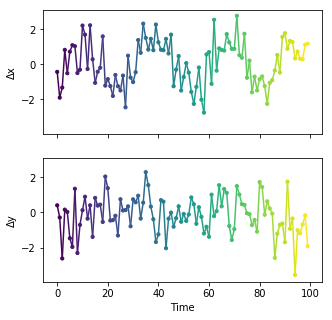

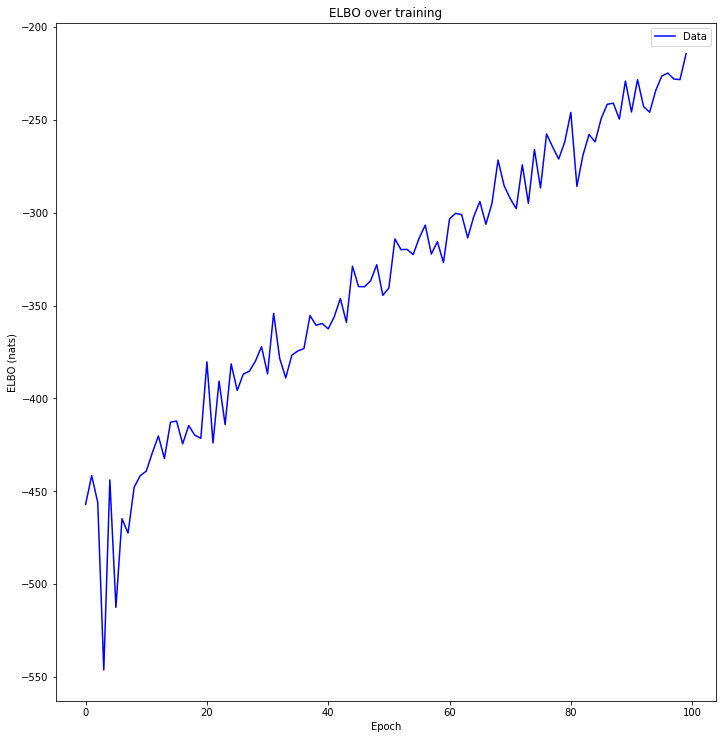

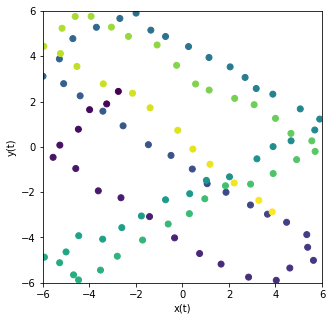

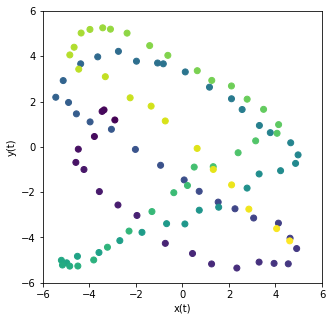

03/01/2019 13:41:44 MSE at time 0: tensor(1.6154)
03/01/2019 13:41:44 MSE at time 1: tensor(0.0836)
03/01/2019 13:41:44 MSE at time 2: tensor(0.2946)
03/01/2019 13:41:44 MSE at time 3: tensor(0.5790)
03/01/2019 13:41:44 MSE at time 4: tensor(0.6623)
03/01/2019 13:41:44 MSE at time 5: tensor(1.0090)
03/01/2019 13:41:44 MSE at time 6: tensor(0.1261)
03/01/2019 13:41:44 MSE at time 7: tensor(0.0032)
03/01/2019 13:41:44 MSE at time 8: tensor(0.1196)
03/01/2019 13:41:44 MSE at time 9: tensor(0.2946)
03/01/2019 13:41:44 MSE at time 10: tensor(0.2180)
03/01/2019 13:41:44 MSE at time 11: tensor(0.0927)
03/01/2019 13:41:44 MSE at time 12: tensor(0.1667)
03/01/2019 13:41:44 MSE at time 13: tensor(0.4161)
03/01/2019 13:41:44 MSE at time 14: tensor(1.1916)
03/01/2019 13:41:44 MSE at time 15: tensor(0.5001)
03/01/2019 13:41:44 MSE at time 16: tensor(1.1956)
03/01/2019 13:41:44 MSE at time 17: tensor(0.2269)
03/01/2019 13:41:44 MSE at time 18: tensor(0.5416)
03/01/2019 13:41:44 MSE at time 19: tenso

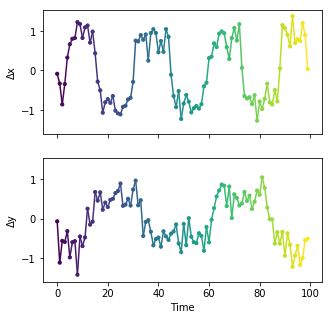

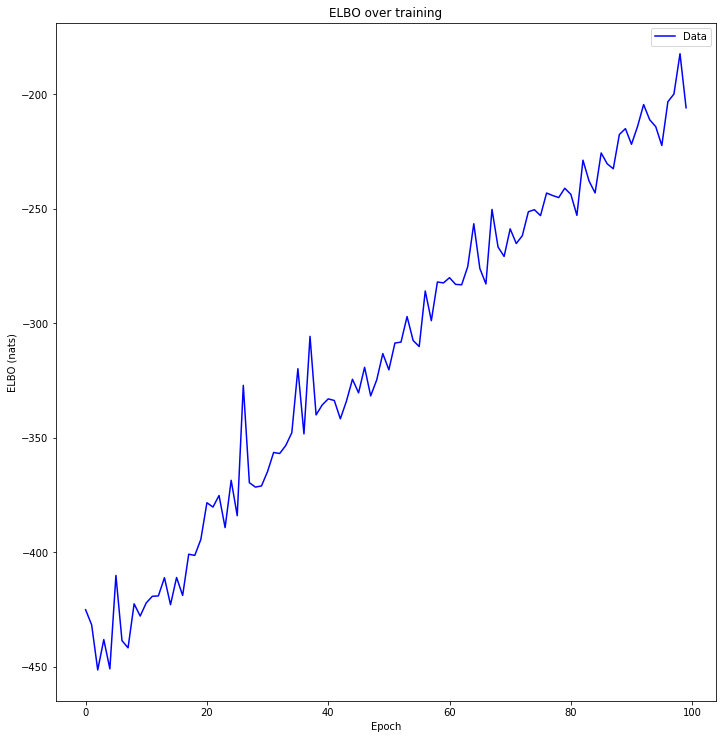

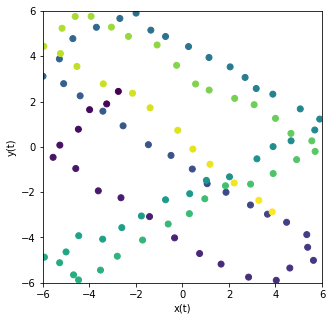

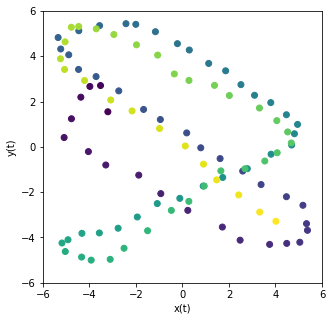

03/01/2019 13:42:06 MSE at time 0: tensor(1.0149)
03/01/2019 13:42:06 MSE at time 1: tensor(0.7282)
03/01/2019 13:42:06 MSE at time 2: tensor(1.0516)
03/01/2019 13:42:06 MSE at time 3: tensor(2.0108)
03/01/2019 13:42:06 MSE at time 4: tensor(1.6047)
03/01/2019 13:42:06 MSE at time 5: tensor(0.9874)
03/01/2019 13:42:06 MSE at time 6: tensor(0.8524)
03/01/2019 13:42:06 MSE at time 7: tensor(1.4016)
03/01/2019 13:42:06 MSE at time 8: tensor(1.5808)
03/01/2019 13:42:06 MSE at time 9: tensor(1.2643)
03/01/2019 13:42:06 MSE at time 10: tensor(1.7981)
03/01/2019 13:42:06 MSE at time 11: tensor(2.3244)
03/01/2019 13:42:06 MSE at time 12: tensor(1.7842)
03/01/2019 13:42:06 MSE at time 13: tensor(2.9067)
03/01/2019 13:42:06 MSE at time 14: tensor(2.8592)
03/01/2019 13:42:06 MSE at time 15: tensor(1.4798)
03/01/2019 13:42:06 MSE at time 16: tensor(1.8245)
03/01/2019 13:42:06 MSE at time 17: tensor(1.0910)
03/01/2019 13:42:06 MSE at time 18: tensor(1.7044)
03/01/2019 13:42:06 MSE at time 19: tenso

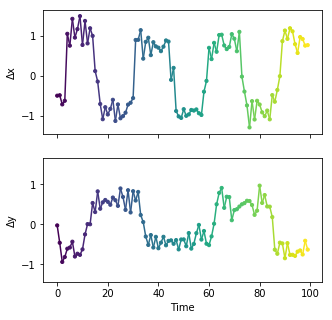

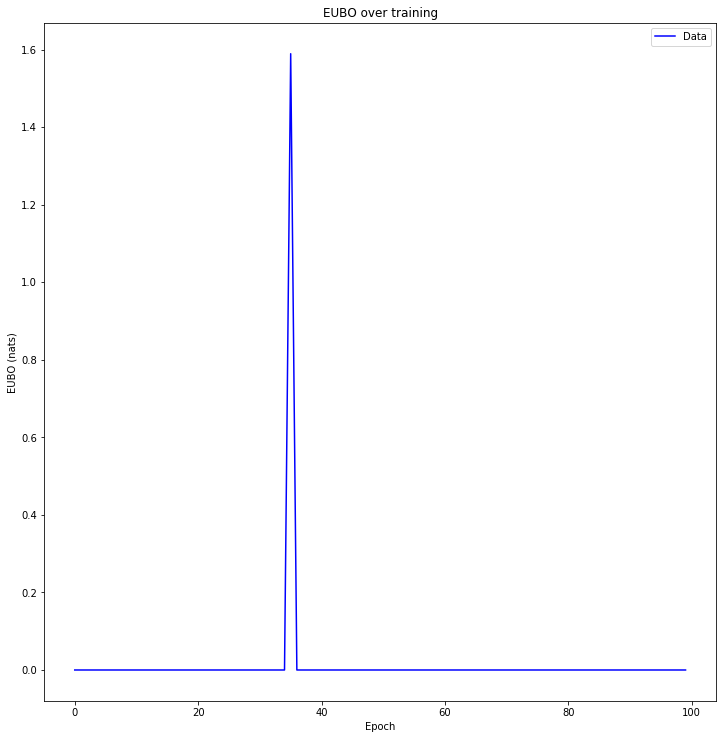

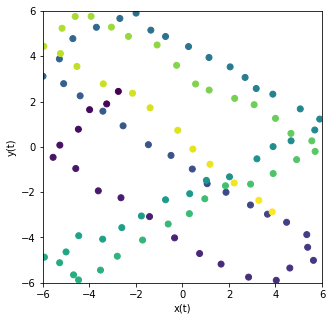

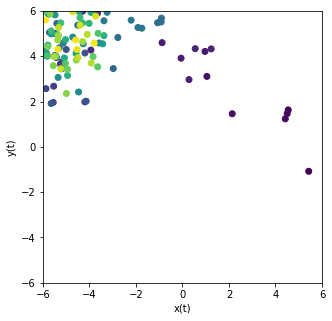

03/01/2019 13:42:26 MSE at time 0: tensor(79.4923)
03/01/2019 13:42:26 MSE at time 1: tensor(61.0271)
03/01/2019 13:42:26 MSE at time 2: tensor(72.2468)
03/01/2019 13:42:26 MSE at time 3: tensor(79.4043)
03/01/2019 13:42:26 MSE at time 4: tensor(56.8773)
03/01/2019 13:42:26 MSE at time 5: tensor(56.5230)
03/01/2019 13:42:26 MSE at time 6: tensor(57.6156)
03/01/2019 13:42:26 MSE at time 7: tensor(50.3128)
03/01/2019 13:42:26 MSE at time 8: tensor(44.6340)
03/01/2019 13:42:26 MSE at time 9: tensor(39.4644)
03/01/2019 13:42:26 MSE at time 10: tensor(72.0687)
03/01/2019 13:42:26 MSE at time 11: tensor(81.8338)
03/01/2019 13:42:26 MSE at time 12: tensor(120.6417)
03/01/2019 13:42:26 MSE at time 13: tensor(188.7319)
03/01/2019 13:42:26 MSE at time 14: tensor(209.1004)
03/01/2019 13:42:26 MSE at time 15: tensor(194.9435)
03/01/2019 13:42:26 MSE at time 16: tensor(193.6025)
03/01/2019 13:42:26 MSE at time 17: tensor(133.0214)
03/01/2019 13:42:26 MSE at time 18: tensor(161.4149)
03/01/2019 13:4

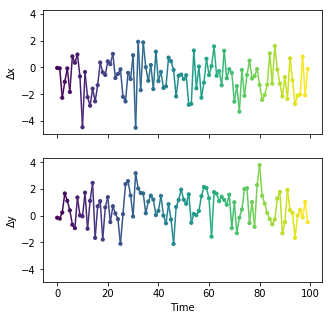

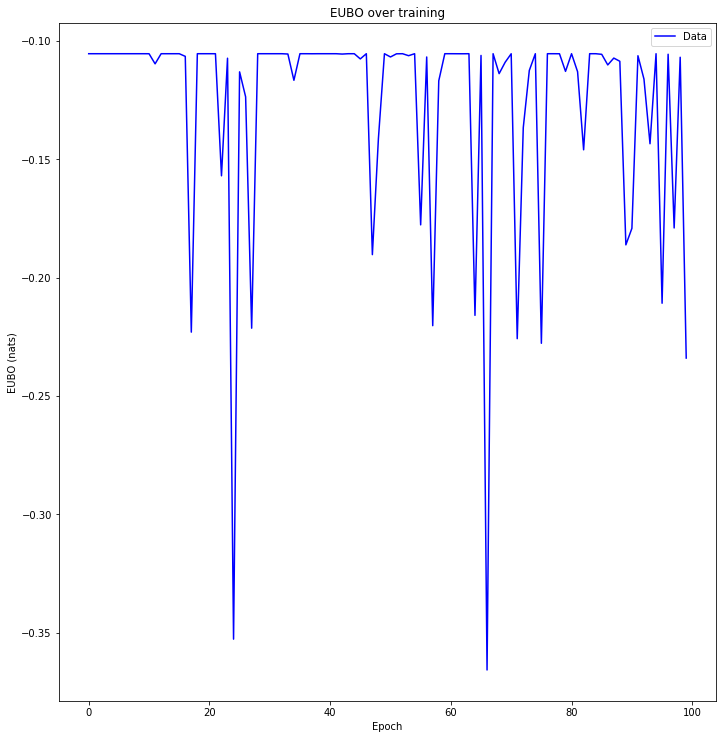

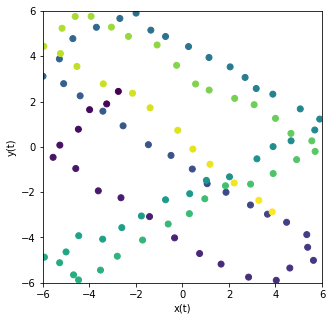

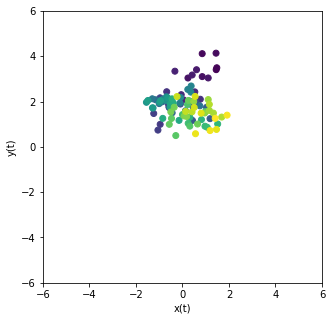

03/01/2019 13:42:44 MSE at time 0: tensor(18.6241)
03/01/2019 13:42:44 MSE at time 1: tensor(24.9791)
03/01/2019 13:42:44 MSE at time 2: tensor(29.5681)
03/01/2019 13:42:44 MSE at time 3: tensor(46.3300)
03/01/2019 13:42:44 MSE at time 4: tensor(46.6601)
03/01/2019 13:42:44 MSE at time 5: tensor(45.8959)
03/01/2019 13:42:44 MSE at time 6: tensor(48.4266)
03/01/2019 13:42:44 MSE at time 7: tensor(46.4306)
03/01/2019 13:42:44 MSE at time 8: tensor(38.7432)
03/01/2019 13:42:44 MSE at time 9: tensor(42.3998)
03/01/2019 13:42:44 MSE at time 10: tensor(37.2655)
03/01/2019 13:42:44 MSE at time 11: tensor(50.9755)
03/01/2019 13:42:44 MSE at time 12: tensor(58.8953)
03/01/2019 13:42:44 MSE at time 13: tensor(66.2748)
03/01/2019 13:42:44 MSE at time 14: tensor(74.5815)
03/01/2019 13:42:44 MSE at time 15: tensor(88.6214)
03/01/2019 13:42:44 MSE at time 16: tensor(87.3553)
03/01/2019 13:42:44 MSE at time 17: tensor(69.6941)
03/01/2019 13:42:44 MSE at time 18: tensor(62.2723)
03/01/2019 13:42:44 MS

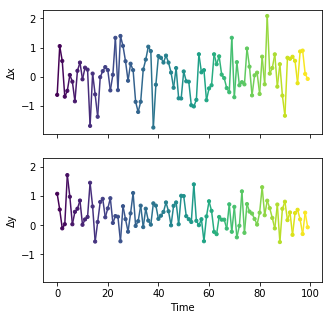

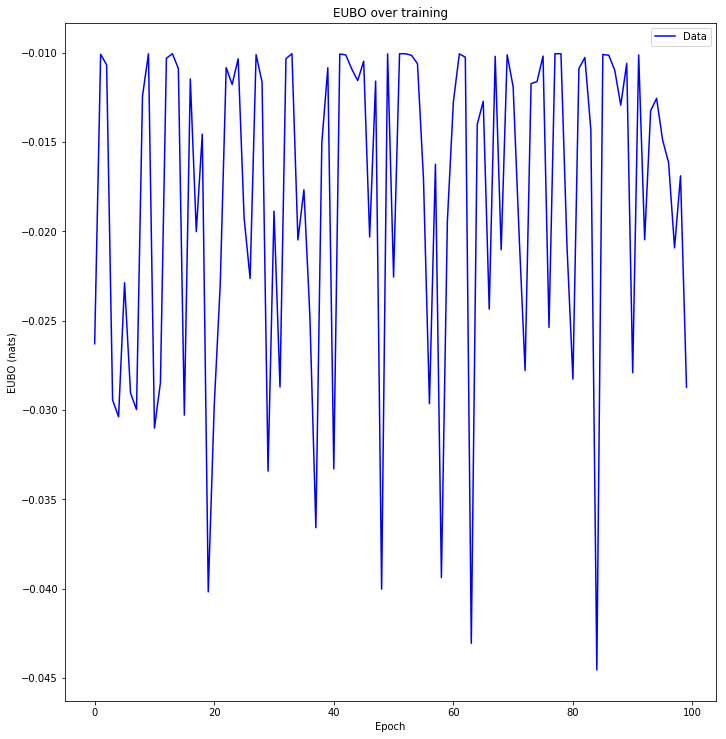

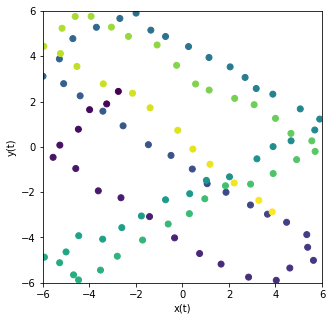

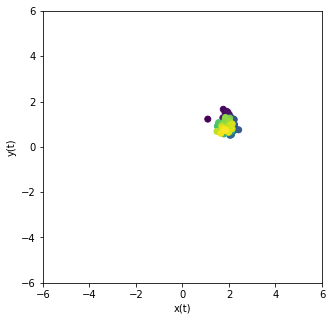

03/01/2019 13:43:02 MSE at time 0: tensor(16.2924)
03/01/2019 13:43:02 MSE at time 1: tensor(26.0790)
03/01/2019 13:43:02 MSE at time 2: tensor(33.0574)
03/01/2019 13:43:02 MSE at time 3: tensor(41.1585)
03/01/2019 13:43:02 MSE at time 4: tensor(54.2640)
03/01/2019 13:43:02 MSE at time 5: tensor(60.9825)
03/01/2019 13:43:02 MSE at time 6: tensor(45.0437)
03/01/2019 13:43:02 MSE at time 7: tensor(40.1707)
03/01/2019 13:43:02 MSE at time 8: tensor(31.8979)
03/01/2019 13:43:02 MSE at time 9: tensor(30.0040)
03/01/2019 13:43:02 MSE at time 10: tensor(29.6897)
03/01/2019 13:43:02 MSE at time 11: tensor(33.6929)
03/01/2019 13:43:02 MSE at time 12: tensor(39.3863)
03/01/2019 13:43:02 MSE at time 13: tensor(47.9630)
03/01/2019 13:43:02 MSE at time 14: tensor(55.7636)
03/01/2019 13:43:02 MSE at time 15: tensor(49.2233)
03/01/2019 13:43:02 MSE at time 16: tensor(48.0620)
03/01/2019 13:43:02 MSE at time 17: tensor(39.8779)
03/01/2019 13:43:02 MSE at time 18: tensor(36.6250)
03/01/2019 13:43:02 MS

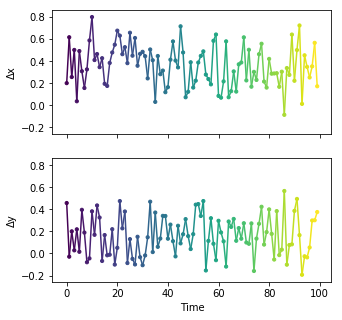

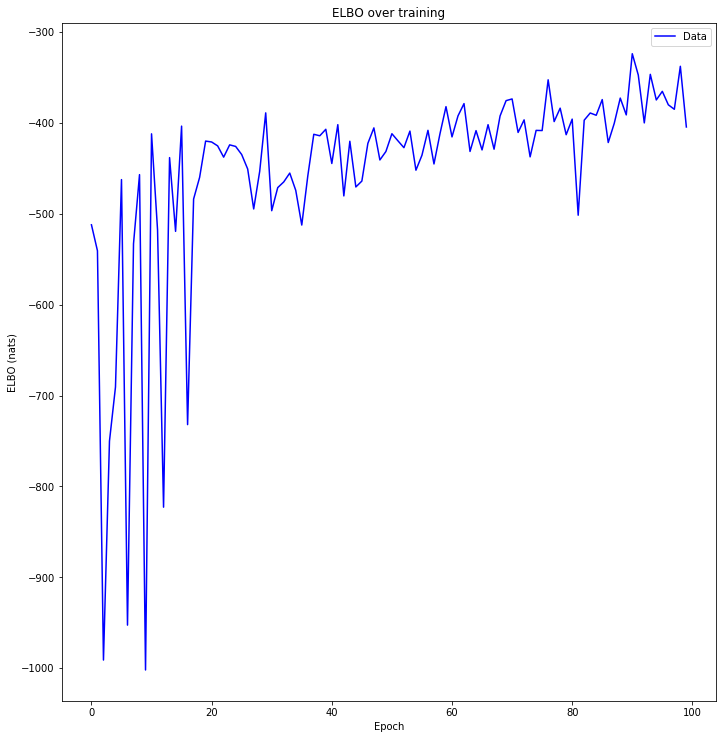

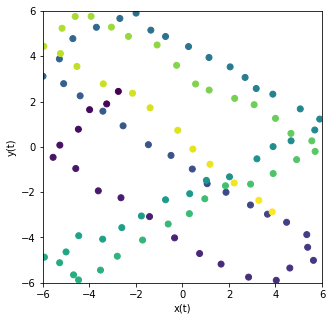

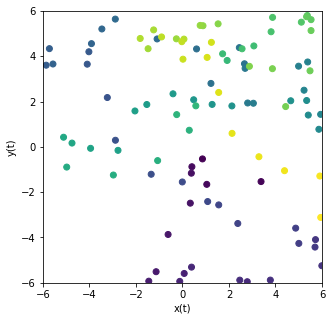

03/01/2019 13:43:26 MSE at time 0: tensor(21.9745)
03/01/2019 13:43:26 MSE at time 1: tensor(55.8413)
03/01/2019 13:43:26 MSE at time 2: tensor(36.2722)
03/01/2019 13:43:26 MSE at time 3: tensor(26.5861)
03/01/2019 13:43:26 MSE at time 4: tensor(33.5225)
03/01/2019 13:43:26 MSE at time 5: tensor(38.9213)
03/01/2019 13:43:26 MSE at time 6: tensor(24.2490)
03/01/2019 13:43:26 MSE at time 7: tensor(18.9305)
03/01/2019 13:43:26 MSE at time 8: tensor(15.0047)
03/01/2019 13:43:26 MSE at time 9: tensor(8.5261)
03/01/2019 13:43:26 MSE at time 10: tensor(3.7417)
03/01/2019 13:43:26 MSE at time 11: tensor(0.4811)
03/01/2019 13:43:26 MSE at time 12: tensor(1.8743)
03/01/2019 13:43:26 MSE at time 13: tensor(0.1613)
03/01/2019 13:43:26 MSE at time 14: tensor(0.0650)
03/01/2019 13:43:26 MSE at time 15: tensor(1.9068)
03/01/2019 13:43:26 MSE at time 16: tensor(0.8454)
03/01/2019 13:43:26 MSE at time 17: tensor(0.1003)
03/01/2019 13:43:26 MSE at time 18: tensor(0.2678)
03/01/2019 13:43:26 MSE at time 

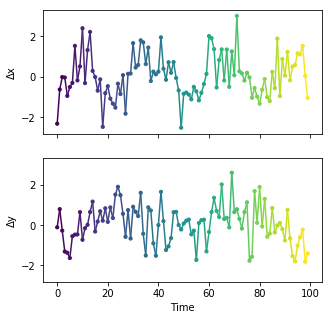

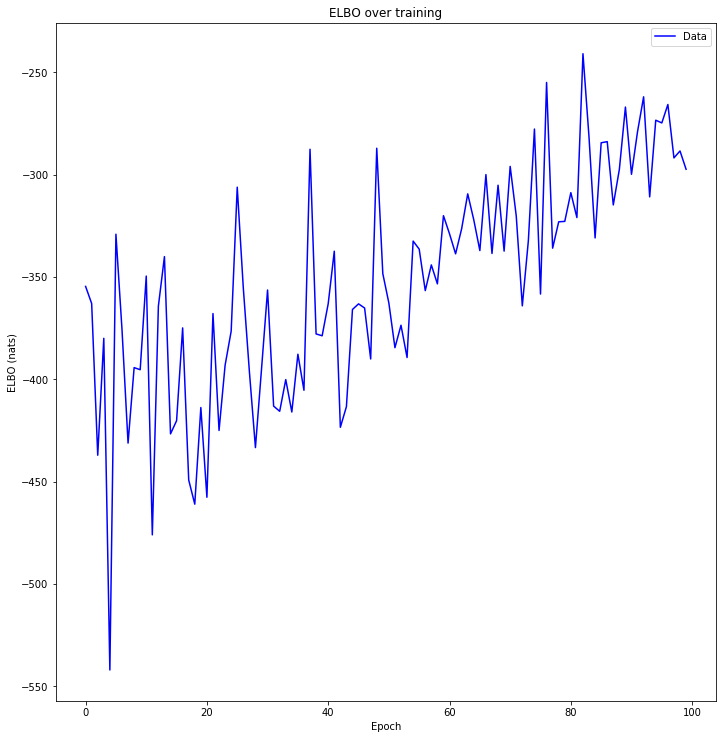

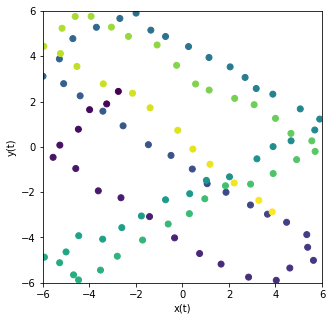

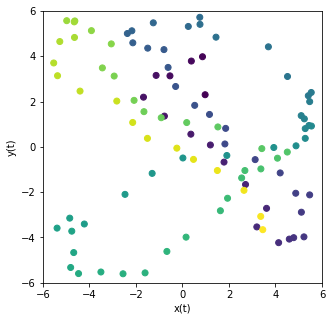

03/01/2019 13:43:52 MSE at time 0: tensor(13.9525)
03/01/2019 13:43:52 MSE at time 1: tensor(21.3206)
03/01/2019 13:43:52 MSE at time 2: tensor(23.7619)
03/01/2019 13:43:52 MSE at time 3: tensor(21.0685)
03/01/2019 13:43:52 MSE at time 4: tensor(26.6208)
03/01/2019 13:43:52 MSE at time 5: tensor(22.1656)
03/01/2019 13:43:52 MSE at time 6: tensor(19.8908)
03/01/2019 13:43:52 MSE at time 7: tensor(22.1020)
03/01/2019 13:43:52 MSE at time 8: tensor(20.2156)
03/01/2019 13:43:52 MSE at time 9: tensor(16.0550)
03/01/2019 13:43:52 MSE at time 10: tensor(14.8633)
03/01/2019 13:43:52 MSE at time 11: tensor(12.2739)
03/01/2019 13:43:52 MSE at time 12: tensor(5.0578)
03/01/2019 13:43:52 MSE at time 13: tensor(3.9845)
03/01/2019 13:43:52 MSE at time 14: tensor(3.6227)
03/01/2019 13:43:52 MSE at time 15: tensor(1.8245)
03/01/2019 13:43:52 MSE at time 16: tensor(1.2415)
03/01/2019 13:43:52 MSE at time 17: tensor(2.4706)
03/01/2019 13:43:52 MSE at time 18: tensor(3.0898)
03/01/2019 13:43:52 MSE at ti

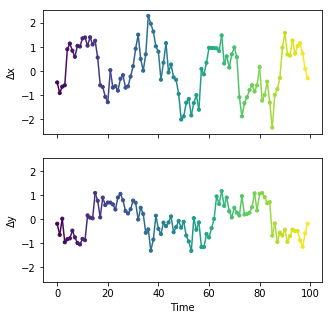

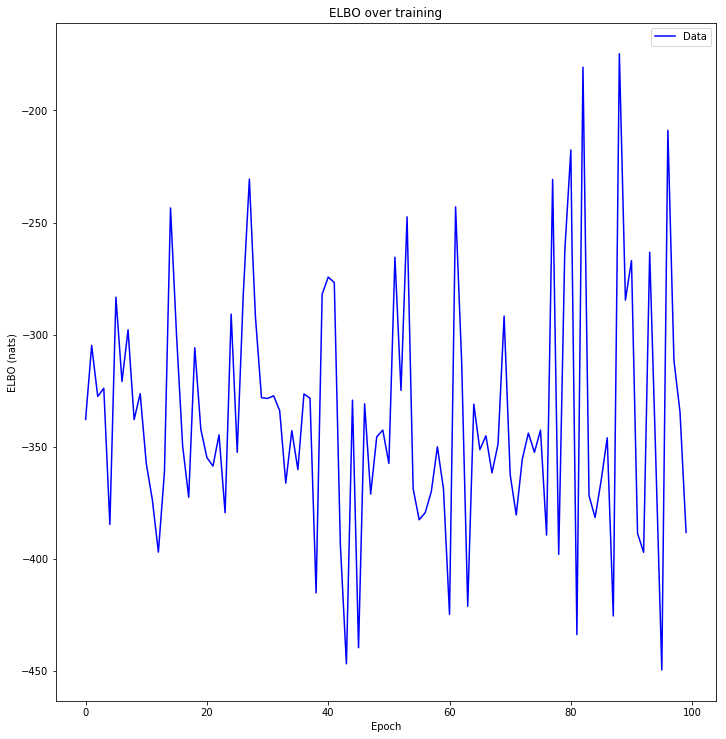

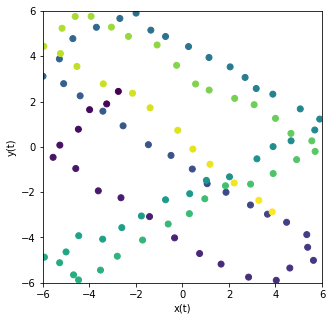

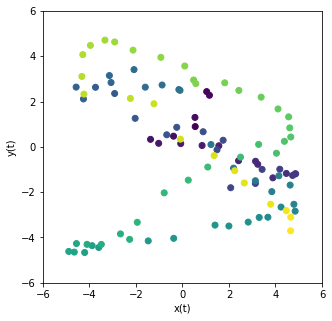

03/01/2019 13:44:21 MSE at time 0: tensor(13.3365)
03/01/2019 13:44:21 MSE at time 1: tensor(18.7953)
03/01/2019 13:44:21 MSE at time 2: tensor(26.9787)
03/01/2019 13:44:21 MSE at time 3: tensor(25.4211)
03/01/2019 13:44:21 MSE at time 4: tensor(24.0648)
03/01/2019 13:44:21 MSE at time 5: tensor(18.1882)
03/01/2019 13:44:21 MSE at time 6: tensor(13.9456)
03/01/2019 13:44:21 MSE at time 7: tensor(16.9103)
03/01/2019 13:44:21 MSE at time 8: tensor(17.4859)
03/01/2019 13:44:21 MSE at time 9: tensor(18.6588)
03/01/2019 13:44:21 MSE at time 10: tensor(19.1714)
03/01/2019 13:44:21 MSE at time 11: tensor(21.7778)
03/01/2019 13:44:21 MSE at time 12: tensor(22.8188)
03/01/2019 13:44:21 MSE at time 13: tensor(20.3074)
03/01/2019 13:44:21 MSE at time 14: tensor(22.4500)
03/01/2019 13:44:21 MSE at time 15: tensor(17.2837)
03/01/2019 13:44:21 MSE at time 16: tensor(15.2121)
03/01/2019 13:44:21 MSE at time 17: tensor(10.4751)
03/01/2019 13:44:21 MSE at time 18: tensor(9.6830)
03/01/2019 13:44:21 MSE

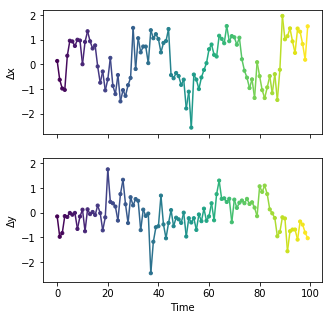

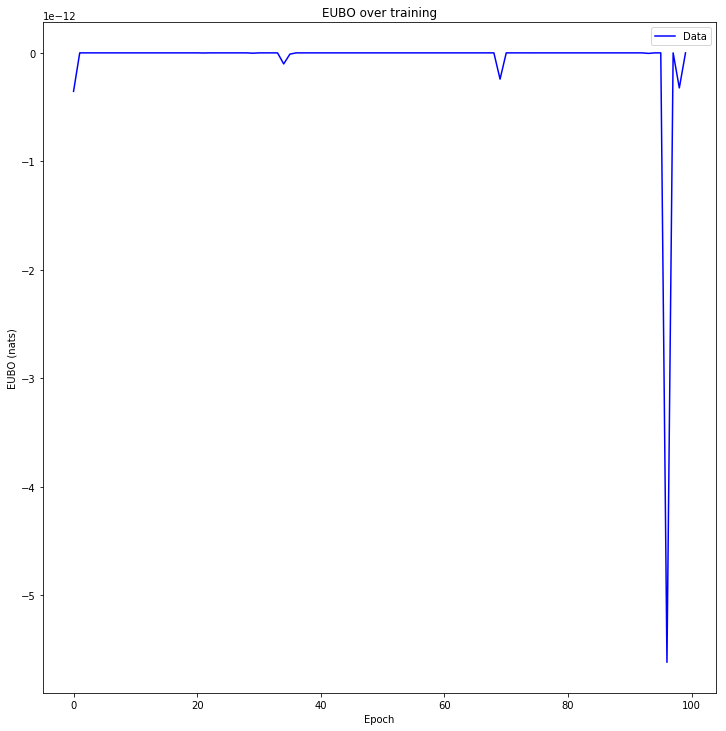

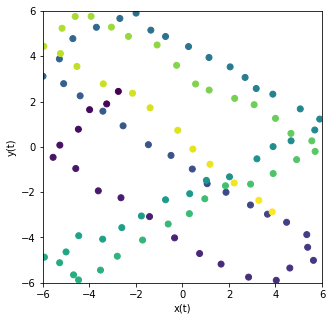

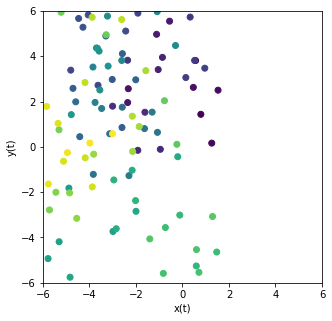

03/01/2019 13:44:38 MSE at time 0: tensor(13.6089)
03/01/2019 13:44:38 MSE at time 1: tensor(18.2816)
03/01/2019 13:44:38 MSE at time 2: tensor(29.7766)
03/01/2019 13:44:38 MSE at time 3: tensor(39.0566)
03/01/2019 13:44:38 MSE at time 4: tensor(39.4746)
03/01/2019 13:44:38 MSE at time 5: tensor(19.6312)
03/01/2019 13:44:38 MSE at time 6: tensor(13.4587)
03/01/2019 13:44:38 MSE at time 7: tensor(65.4871)
03/01/2019 13:44:38 MSE at time 8: tensor(54.4124)
03/01/2019 13:44:38 MSE at time 9: tensor(42.2595)
03/01/2019 13:44:38 MSE at time 10: tensor(63.7721)
03/01/2019 13:44:38 MSE at time 11: tensor(24.0249)
03/01/2019 13:44:38 MSE at time 12: tensor(38.0527)
03/01/2019 13:44:38 MSE at time 13: tensor(72.8714)
03/01/2019 13:44:38 MSE at time 14: tensor(108.6758)
03/01/2019 13:44:38 MSE at time 15: tensor(132.8397)
03/01/2019 13:44:38 MSE at time 16: tensor(143.4760)
03/01/2019 13:44:38 MSE at time 17: tensor(91.6914)
03/01/2019 13:44:38 MSE at time 18: tensor(75.1528)
03/01/2019 13:44:38

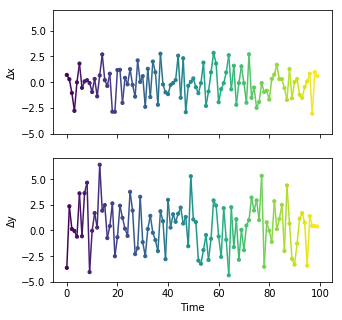

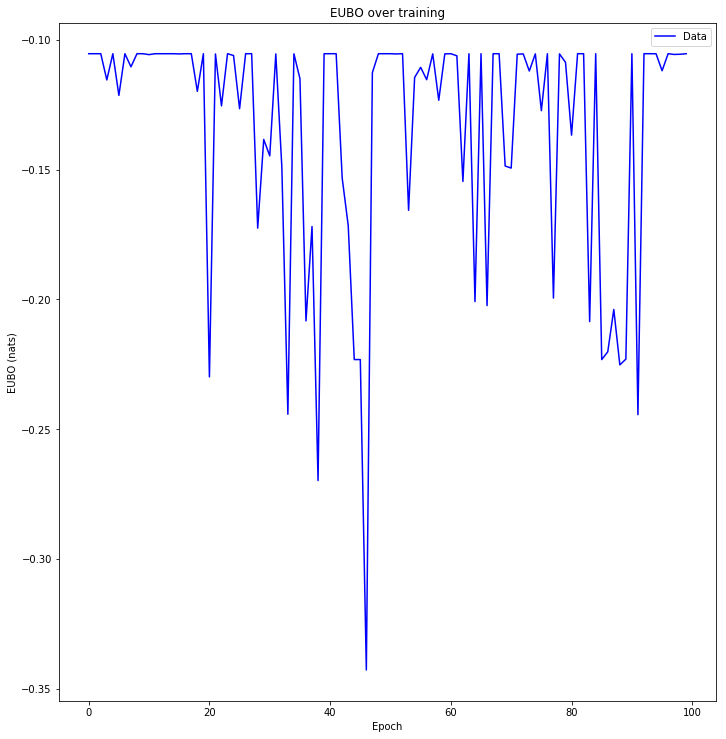

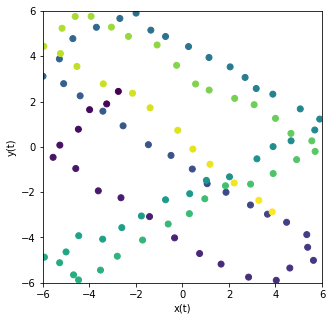

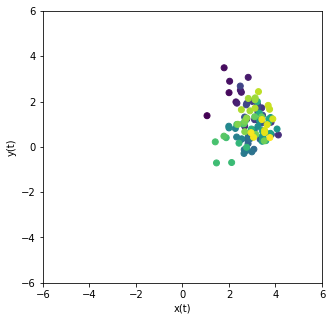

03/01/2019 13:44:55 MSE at time 0: tensor(15.6982)
03/01/2019 13:44:55 MSE at time 1: tensor(36.7026)
03/01/2019 13:44:55 MSE at time 2: tensor(36.5329)
03/01/2019 13:44:55 MSE at time 3: tensor(46.6564)
03/01/2019 13:44:55 MSE at time 4: tensor(61.2922)
03/01/2019 13:44:55 MSE at time 5: tensor(67.8322)
03/01/2019 13:44:55 MSE at time 6: tensor(62.0630)
03/01/2019 13:44:55 MSE at time 7: tensor(66.6637)
03/01/2019 13:44:55 MSE at time 8: tensor(48.9285)
03/01/2019 13:44:55 MSE at time 9: tensor(39.2018)
03/01/2019 13:44:55 MSE at time 10: tensor(33.3720)
03/01/2019 13:44:55 MSE at time 11: tensor(39.6701)
03/01/2019 13:44:55 MSE at time 12: tensor(42.7722)
03/01/2019 13:44:55 MSE at time 13: tensor(41.0395)
03/01/2019 13:44:55 MSE at time 14: tensor(48.7593)
03/01/2019 13:44:55 MSE at time 15: tensor(39.4209)
03/01/2019 13:44:55 MSE at time 16: tensor(50.2653)
03/01/2019 13:44:55 MSE at time 17: tensor(36.9497)
03/01/2019 13:44:55 MSE at time 18: tensor(40.0825)
03/01/2019 13:44:55 MS

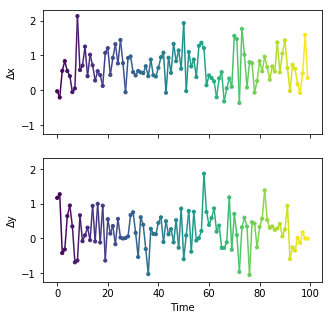

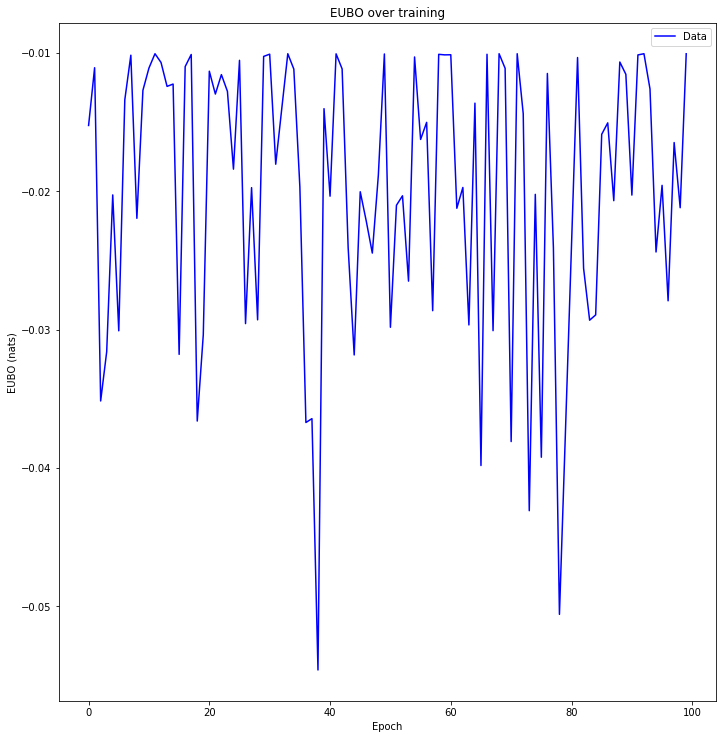

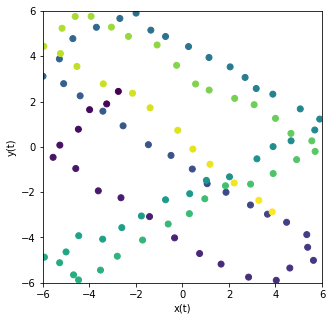

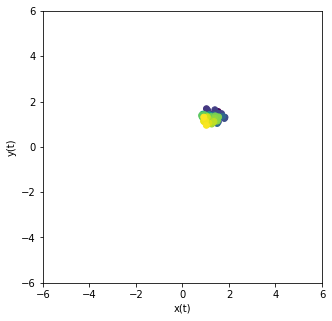

03/01/2019 13:45:13 MSE at time 0: tensor(15.7537)
03/01/2019 13:45:13 MSE at time 1: tensor(23.0823)
03/01/2019 13:45:13 MSE at time 2: tensor(30.7258)
03/01/2019 13:45:13 MSE at time 3: tensor(36.7035)
03/01/2019 13:45:13 MSE at time 4: tensor(44.9525)
03/01/2019 13:45:13 MSE at time 5: tensor(46.6527)
03/01/2019 13:45:13 MSE at time 6: tensor(36.7792)
03/01/2019 13:45:13 MSE at time 7: tensor(35.3017)
03/01/2019 13:45:13 MSE at time 8: tensor(28.3562)
03/01/2019 13:45:13 MSE at time 9: tensor(26.2605)
03/01/2019 13:45:13 MSE at time 10: tensor(30.5531)
03/01/2019 13:45:13 MSE at time 11: tensor(34.9996)
03/01/2019 13:45:13 MSE at time 12: tensor(40.9612)
03/01/2019 13:45:13 MSE at time 13: tensor(51.5974)
03/01/2019 13:45:13 MSE at time 14: tensor(59.5522)
03/01/2019 13:45:13 MSE at time 15: tensor(57.8241)
03/01/2019 13:45:13 MSE at time 16: tensor(65.9630)
03/01/2019 13:45:13 MSE at time 17: tensor(55.0054)
03/01/2019 13:45:13 MSE at time 18: tensor(45.9862)
03/01/2019 13:45:13 MS

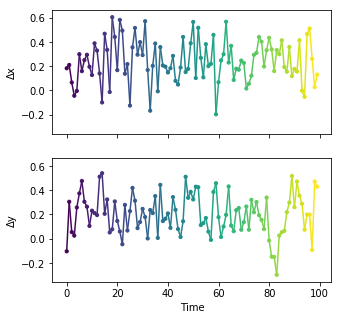

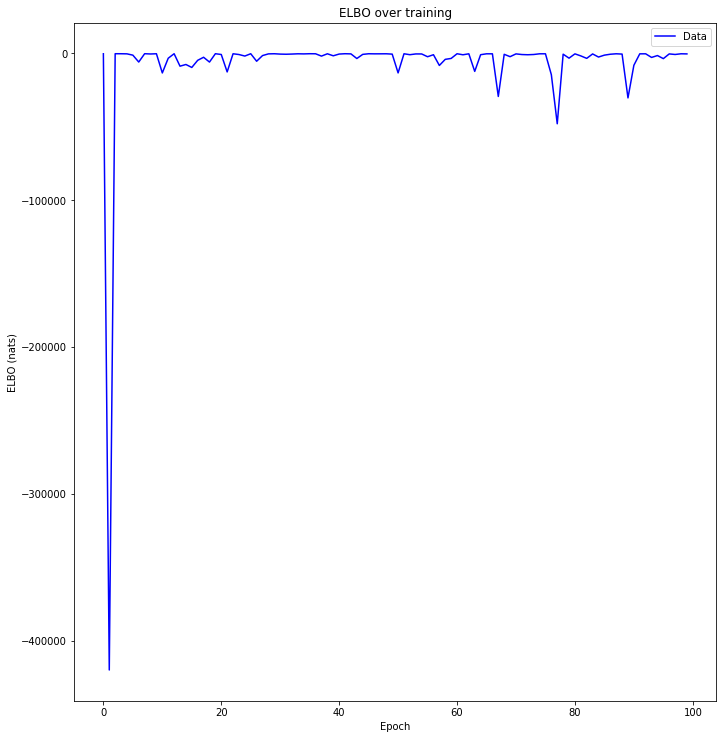

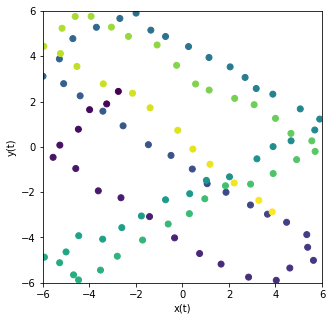

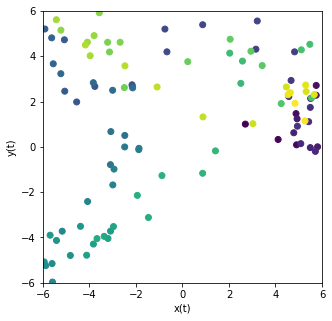

03/01/2019 13:47:47 MSE at time 0: tensor(31.9159)
03/01/2019 13:47:47 MSE at time 1: tensor(56.8313)
03/01/2019 13:47:47 MSE at time 2: tensor(81.6256)
03/01/2019 13:47:47 MSE at time 3: tensor(88.1144)
03/01/2019 13:47:47 MSE at time 4: tensor(128.5362)
03/01/2019 13:47:47 MSE at time 5: tensor(129.5142)
03/01/2019 13:47:47 MSE at time 6: tensor(117.4043)
03/01/2019 13:47:47 MSE at time 7: tensor(83.1938)
03/01/2019 13:47:47 MSE at time 8: tensor(76.5571)
03/01/2019 13:47:47 MSE at time 9: tensor(52.1921)
03/01/2019 13:47:47 MSE at time 10: tensor(49.9609)
03/01/2019 13:47:47 MSE at time 11: tensor(45.1303)
03/01/2019 13:47:47 MSE at time 12: tensor(40.0248)
03/01/2019 13:47:47 MSE at time 13: tensor(53.7613)
03/01/2019 13:47:47 MSE at time 14: tensor(60.4290)
03/01/2019 13:47:47 MSE at time 15: tensor(39.3095)
03/01/2019 13:47:47 MSE at time 16: tensor(53.4067)
03/01/2019 13:47:47 MSE at time 17: tensor(54.7537)
03/01/2019 13:47:47 MSE at time 18: tensor(65.3858)
03/01/2019 13:47:47

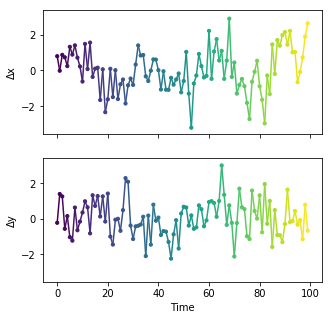

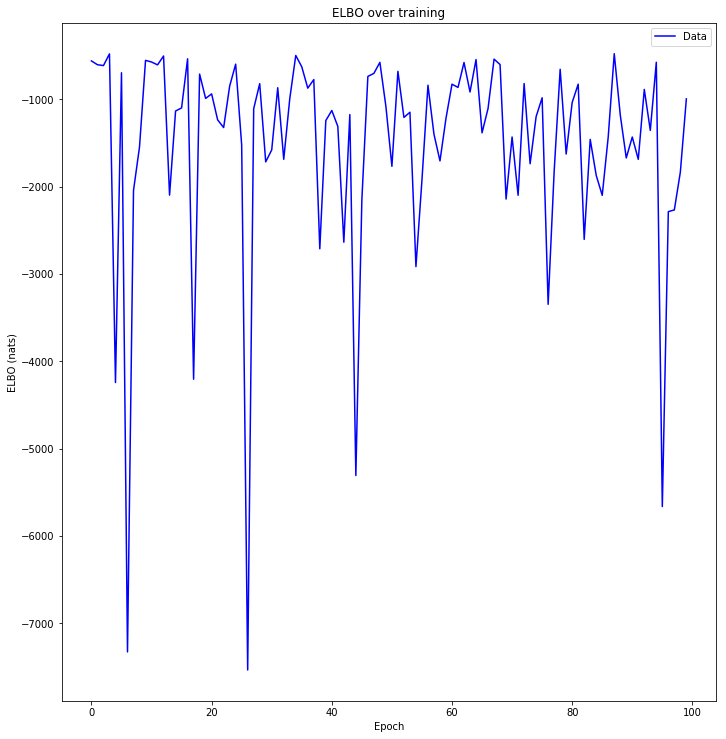

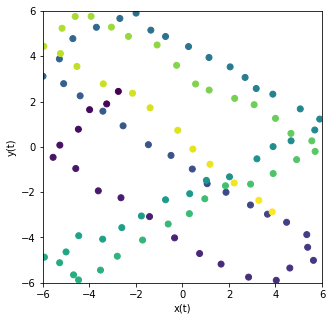

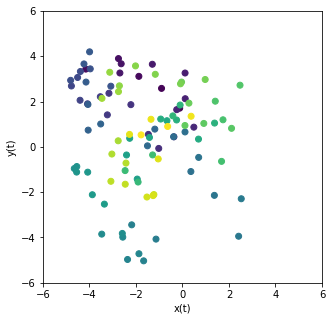

03/01/2019 13:50:14 MSE at time 0: tensor(7.5041)
03/01/2019 13:50:14 MSE at time 1: tensor(6.0364)
03/01/2019 13:50:14 MSE at time 2: tensor(6.6556)
03/01/2019 13:50:14 MSE at time 3: tensor(7.1501)
03/01/2019 13:50:14 MSE at time 4: tensor(20.9608)
03/01/2019 13:50:14 MSE at time 5: tensor(25.6336)
03/01/2019 13:50:14 MSE at time 6: tensor(21.3870)
03/01/2019 13:50:14 MSE at time 7: tensor(36.6170)
03/01/2019 13:50:14 MSE at time 8: tensor(37.9158)
03/01/2019 13:50:14 MSE at time 9: tensor(29.4431)
03/01/2019 13:50:14 MSE at time 10: tensor(32.0463)
03/01/2019 13:50:14 MSE at time 11: tensor(31.1843)
03/01/2019 13:50:14 MSE at time 12: tensor(35.6827)
03/01/2019 13:50:14 MSE at time 13: tensor(47.2187)
03/01/2019 13:50:14 MSE at time 14: tensor(71.7556)
03/01/2019 13:50:14 MSE at time 15: tensor(98.7486)
03/01/2019 13:50:14 MSE at time 16: tensor(131.7784)
03/01/2019 13:50:14 MSE at time 17: tensor(108.3933)
03/01/2019 13:50:14 MSE at time 18: tensor(115.9173)
03/01/2019 13:50:14 MSE

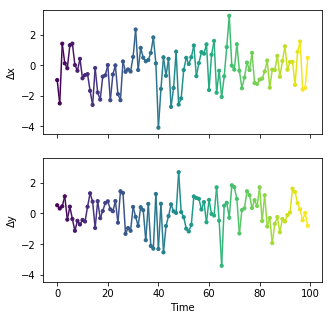

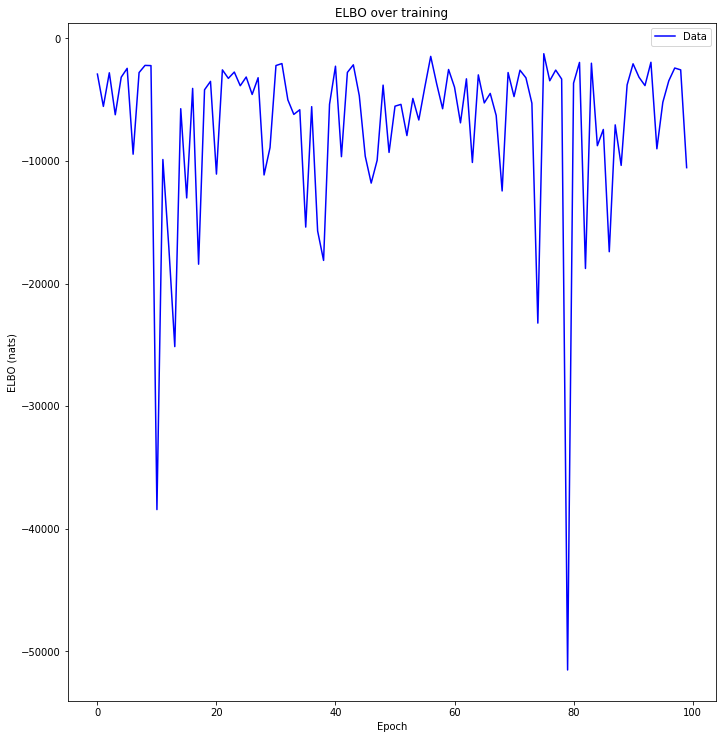

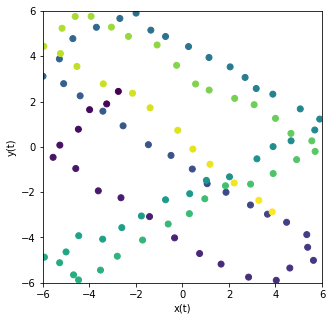

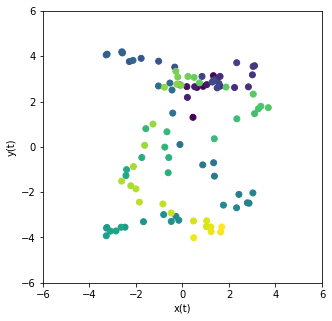

03/01/2019 13:53:00 MSE at time 0: tensor(11.6147)
03/01/2019 13:53:00 MSE at time 1: tensor(17.8069)
03/01/2019 13:53:00 MSE at time 2: tensor(30.6072)
03/01/2019 13:53:00 MSE at time 3: tensor(29.4065)
03/01/2019 13:53:00 MSE at time 4: tensor(36.4957)
03/01/2019 13:53:00 MSE at time 5: tensor(40.0764)
03/01/2019 13:53:00 MSE at time 6: tensor(45.4442)
03/01/2019 13:53:00 MSE at time 7: tensor(48.0261)
03/01/2019 13:53:00 MSE at time 8: tensor(34.0807)
03/01/2019 13:53:00 MSE at time 9: tensor(30.3487)
03/01/2019 13:53:00 MSE at time 10: tensor(48.6799)
03/01/2019 13:53:00 MSE at time 11: tensor(59.8710)
03/01/2019 13:53:00 MSE at time 12: tensor(68.6776)
03/01/2019 13:53:00 MSE at time 13: tensor(70.4452)
03/01/2019 13:53:00 MSE at time 14: tensor(74.3766)
03/01/2019 13:53:00 MSE at time 15: tensor(75.3369)
03/01/2019 13:53:00 MSE at time 16: tensor(80.0303)
03/01/2019 13:53:00 MSE at time 17: tensor(69.4591)
03/01/2019 13:53:00 MSE at time 18: tensor(66.6908)
03/01/2019 13:53:00 MS

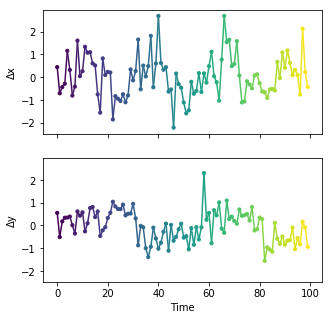

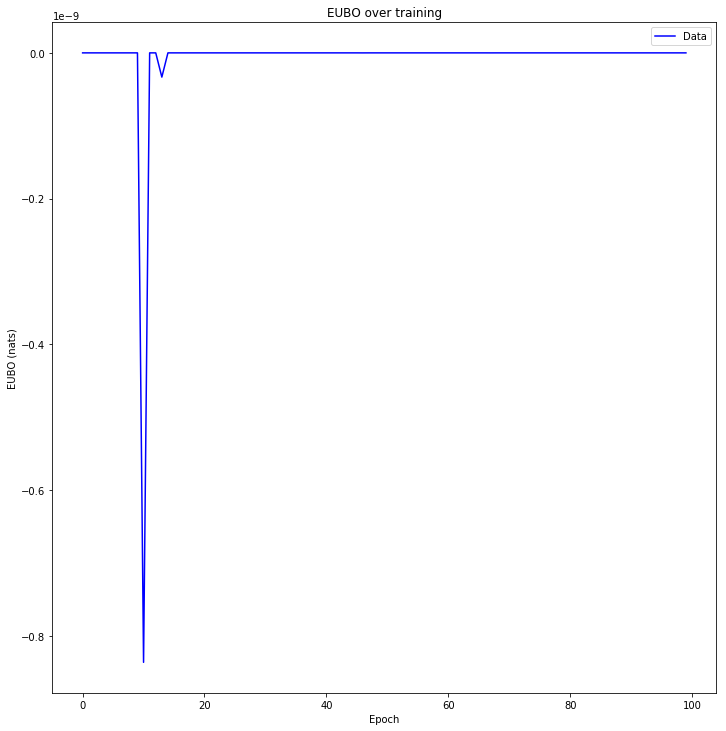

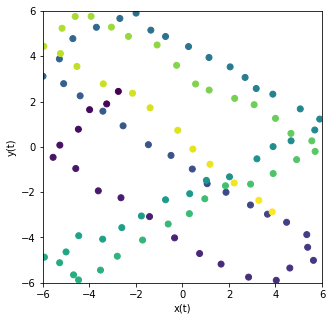

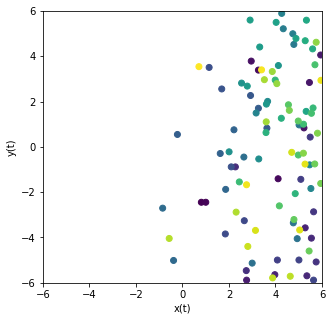

03/01/2019 13:53:18 MSE at time 0: tensor(36.7080)
03/01/2019 13:53:18 MSE at time 1: tensor(37.0199)
03/01/2019 13:53:18 MSE at time 2: tensor(75.0393)
03/01/2019 13:53:18 MSE at time 3: tensor(66.7767)
03/01/2019 13:53:18 MSE at time 4: tensor(81.5330)
03/01/2019 13:53:18 MSE at time 5: tensor(118.0945)
03/01/2019 13:53:18 MSE at time 6: tensor(115.4276)
03/01/2019 13:53:18 MSE at time 7: tensor(127.4341)
03/01/2019 13:53:18 MSE at time 8: tensor(42.4306)
03/01/2019 13:53:18 MSE at time 9: tensor(35.6186)
03/01/2019 13:53:18 MSE at time 10: tensor(31.7558)
03/01/2019 13:53:18 MSE at time 11: tensor(22.2622)
03/01/2019 13:53:18 MSE at time 12: tensor(16.4064)
03/01/2019 13:53:18 MSE at time 13: tensor(24.0069)
03/01/2019 13:53:18 MSE at time 14: tensor(1.8485)
03/01/2019 13:53:18 MSE at time 15: tensor(1.3537)
03/01/2019 13:53:18 MSE at time 16: tensor(4.5926)
03/01/2019 13:53:18 MSE at time 17: tensor(23.6725)
03/01/2019 13:53:18 MSE at time 18: tensor(6.0190)
03/01/2019 13:53:18 MSE

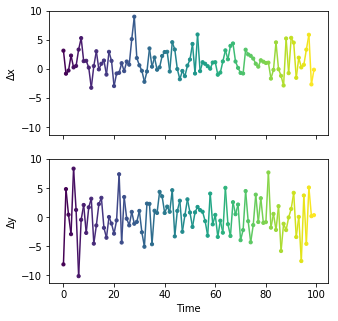

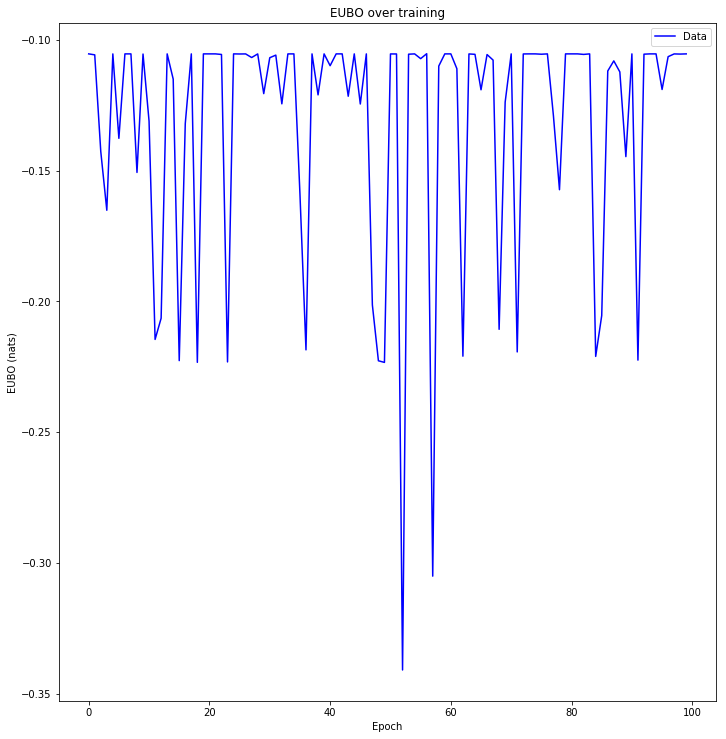

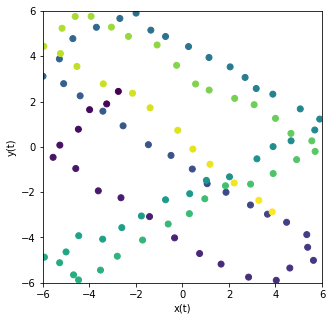

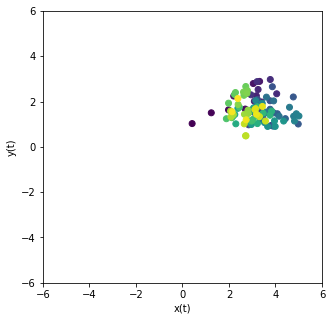

03/01/2019 13:53:32 MSE at time 0: tensor(12.0871)
03/01/2019 13:53:32 MSE at time 1: tensor(20.3968)
03/01/2019 13:53:32 MSE at time 2: tensor(35.6871)
03/01/2019 13:53:32 MSE at time 3: tensor(52.2968)
03/01/2019 13:53:32 MSE at time 4: tensor(60.6456)
03/01/2019 13:53:32 MSE at time 5: tensor(84.7323)
03/01/2019 13:53:32 MSE at time 6: tensor(77.3139)
03/01/2019 13:53:32 MSE at time 7: tensor(59.8878)
03/01/2019 13:53:32 MSE at time 8: tensor(54.4139)
03/01/2019 13:53:32 MSE at time 9: tensor(46.2558)
03/01/2019 13:53:32 MSE at time 10: tensor(51.7475)
03/01/2019 13:53:32 MSE at time 11: tensor(58.7801)
03/01/2019 13:53:32 MSE at time 12: tensor(62.2676)
03/01/2019 13:53:32 MSE at time 13: tensor(77.0017)
03/01/2019 13:53:32 MSE at time 14: tensor(77.6230)
03/01/2019 13:53:32 MSE at time 15: tensor(61.2539)
03/01/2019 13:53:32 MSE at time 16: tensor(53.8329)
03/01/2019 13:53:32 MSE at time 17: tensor(41.6046)
03/01/2019 13:53:32 MSE at time 18: tensor(34.1233)
03/01/2019 13:53:32 MS

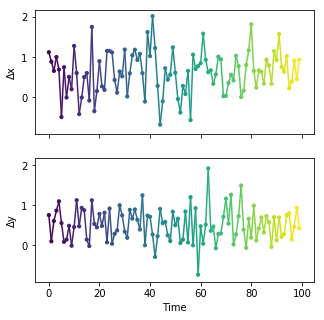

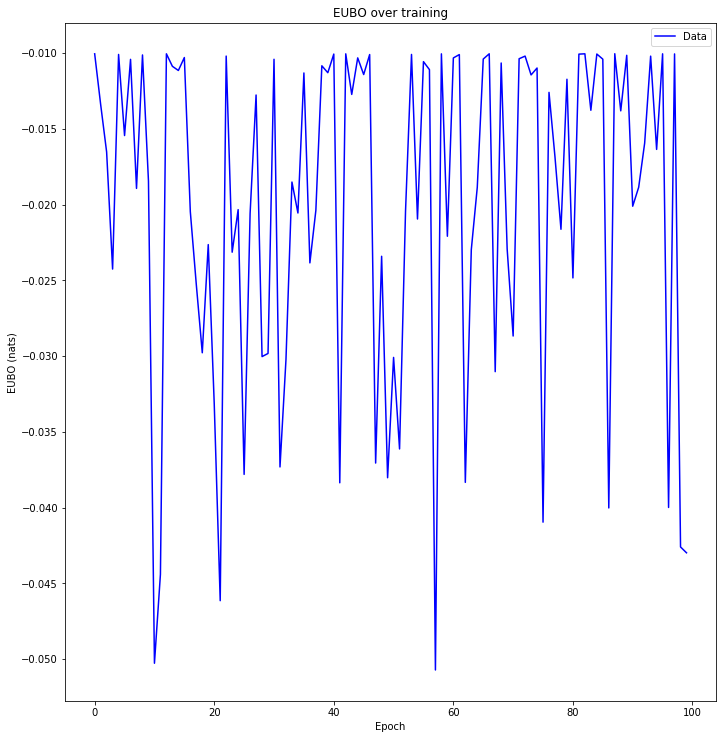

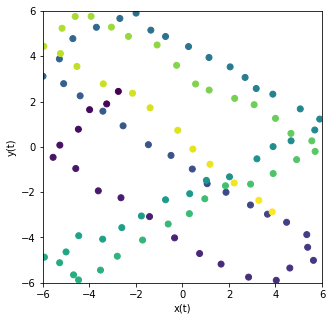

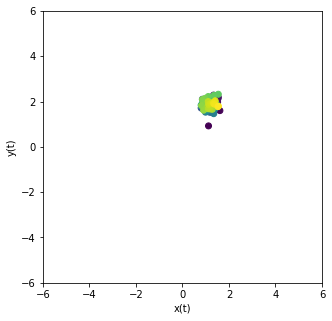

03/01/2019 13:53:48 MSE at time 0: tensor(17.3593)
03/01/2019 13:53:48 MSE at time 1: tensor(23.7999)
03/01/2019 13:53:48 MSE at time 2: tensor(30.2767)
03/01/2019 13:53:48 MSE at time 3: tensor(37.2898)
03/01/2019 13:53:48 MSE at time 4: tensor(50.9104)
03/01/2019 13:53:48 MSE at time 5: tensor(57.0794)
03/01/2019 13:53:48 MSE at time 6: tensor(44.4514)
03/01/2019 13:53:48 MSE at time 7: tensor(39.1696)
03/01/2019 13:53:48 MSE at time 8: tensor(36.3804)
03/01/2019 13:53:48 MSE at time 9: tensor(33.7385)
03/01/2019 13:53:48 MSE at time 10: tensor(37.7961)
03/01/2019 13:53:48 MSE at time 11: tensor(43.3947)
03/01/2019 13:53:48 MSE at time 12: tensor(50.6900)
03/01/2019 13:53:48 MSE at time 13: tensor(59.9287)
03/01/2019 13:53:48 MSE at time 14: tensor(67.5825)
03/01/2019 13:53:48 MSE at time 15: tensor(63.9346)
03/01/2019 13:53:48 MSE at time 16: tensor(65.9486)
03/01/2019 13:53:48 MSE at time 17: tensor(60.0376)
03/01/2019 13:53:48 MSE at time 18: tensor(54.2238)
03/01/2019 13:53:48 MS

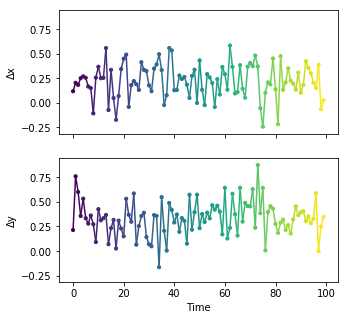

In [24]:
for i, inference_strategy in enumerate(sampling_strategies):
    logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
    for inclusive_kl in kl_directions:
        logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
        for num_particles in sample_sizes:
            logging.info('Experimenting with sample size of %d', num_particles)
            sampler, tau = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True)
            evaluate_inference(sampler, tau)